In [7]:
import pandas as pd

df = pd.read_csv('realistic_taxi_data_mew.csv')
df1_injectedd = pd.read_csv('injected_data.csv')

<Axes: >

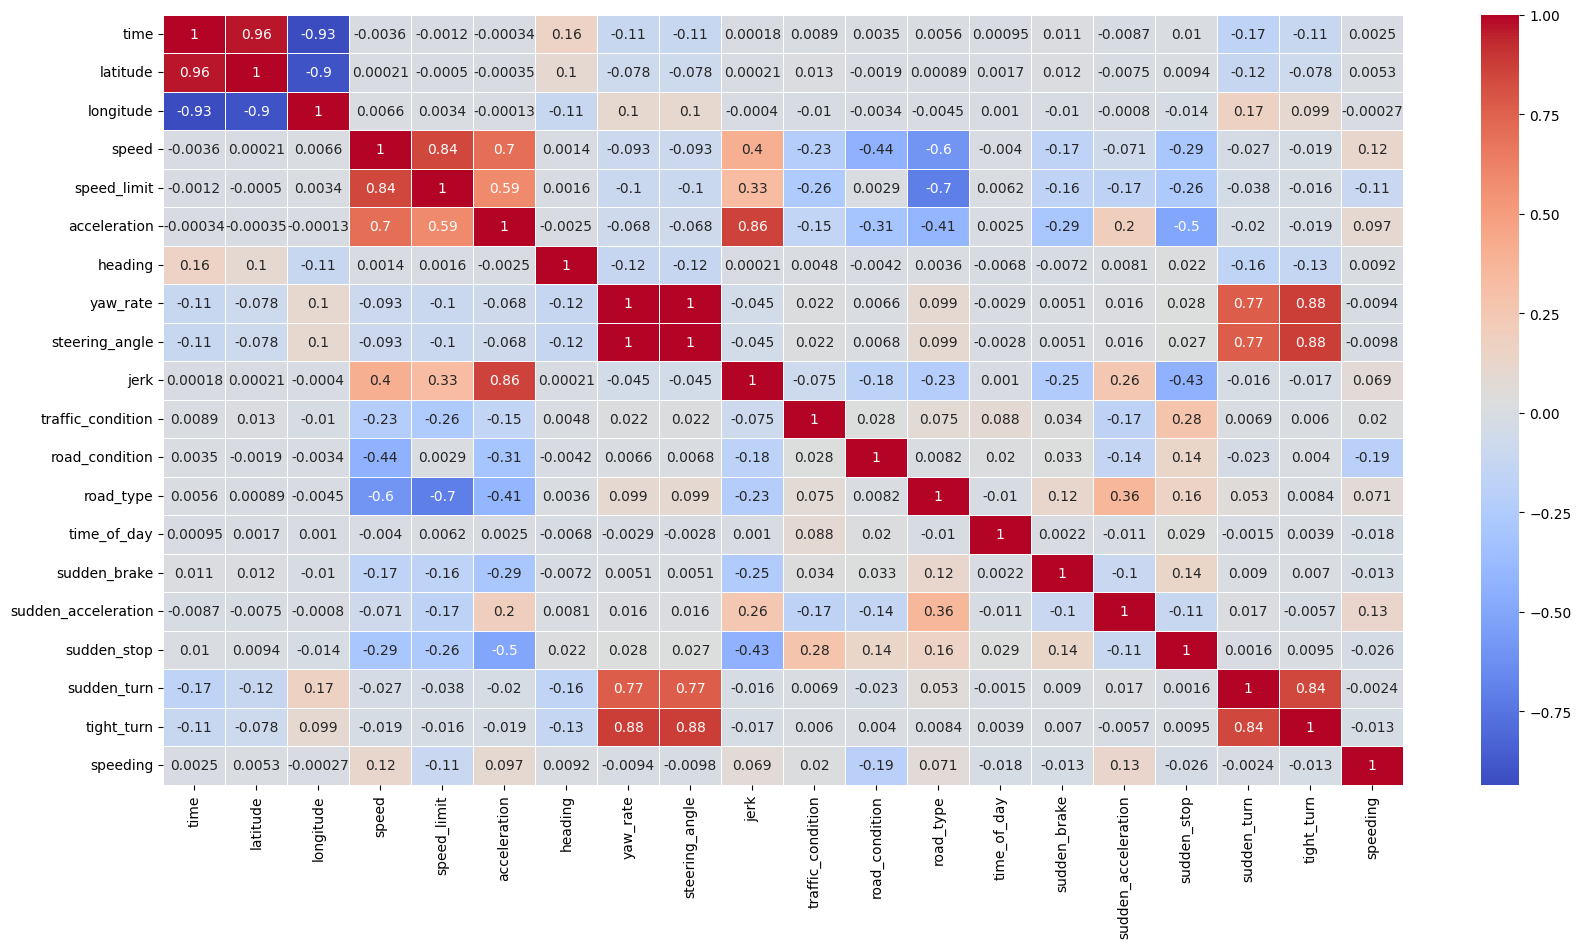

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns;  # for plot stylingdf


plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)

In [9]:
print(df[['sudden_brake', 'sudden_acceleration', 'sudden_stop','sudden_turn', 'tight_turn', 'speeding']].sum())


sudden_brake           563
sudden_acceleration    559
sudden_stop            658
sudden_turn            380
tight_turn             298
speeding               529
dtype: int64


In [10]:
print(df1_injectedd[['sudden_brake', 'sudden_acceleration', 'sudden_stop','sudden_turn', 'tight_turn', 'speeding']].sum())


sudden_brake           5
sudden_acceleration    5
sudden_stop            5
sudden_turn            5
tight_turn             5
speeding               5
dtype: int64


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import joblib

X = df.drop(columns=[
    'time', 'latitude', 'longitude',
    'sudden_brake', 'sudden_acceleration', 'sudden_stop',
    'sudden_turn', 'tight_turn', 'speeding'
])

y = df[[ "sudden_brake", "sudden_acceleration", "sudden_turn", "tight_turn","speeding","sudden_stop"]]




In [12]:
y.sum()

sudden_brake           563
sudden_acceleration    559
sudden_turn            380
tight_turn             298
speeding               529
sudden_stop            658
dtype: int64

In [13]:
X


,speed,speed_limit,acceleration,heading,yaw_rate,steering_angle,jerk,traffic_condition,road_condition,road_type,time_of_day
0,48.390301,50,0.000000,0.000000,0.000000,0.149945,0.000000,0,0,1,2
1,71.940331,110,11.775015,235.304846,94.121939,62.780577,11.775015,0,2,0,2
2,54.690576,50,-10.349853,237.994617,2.689770,1.998151,-22.124868,1,1,1,3
3,40.962039,50,-8.237122,234.462322,3.532295,2.542088,2.112731,0,0,1,2
4,72.780601,50,19.091137,225.000000,9.462322,6.020355,28.449325,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5911,73.285383,70,23.105310,57.765566,0.981125,0.972550,16.849349,1,0,2,1
5912,103.373260,110,15.043938,50.722194,2.817349,2.138993,-8.061371,0,0,0,3
5913,92.058773,110,-5.657243,50.466582,0.102245,-0.147868,-20.701182,2,1,0,0
5914,54.774261,70,-22.370707,50.766023,0.359329,0.254176,-13.452132,2,1,2,2


# Random Forest MultiOutput anomaly detector

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = RandomForestClassifier(n_estimators=200, random_state=42)
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

y_pred = multi_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=y.columns,zero_division=1))

# joblib.dump(multi_model, 'anomaly_multi_model.pkl')
# print(" Model saved as 'anomaly_multi_model.pkl'")


                     precision    recall  f1-score   support

       sudden_brake       0.50      0.02      0.03       129
sudden_acceleration       0.94      0.99      0.97       120
        sudden_turn       1.00      1.00      1.00        73
         tight_turn       1.00      1.00      1.00        54
           speeding       0.76      0.86      0.81       101
        sudden_stop       0.74      0.95      0.83       138

          micro avg       0.85      0.76      0.80       615
          macro avg       0.82      0.80      0.77       615
       weighted avg       0.79      0.76      0.72       615
        samples avg       0.94      0.90      0.85       615



# Trip Rating Model

In [16]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
import pickle
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv("trip_violation_dataset.csv")
data

,trip_id,trip_length,sudden_brake,sudden_acceleration,sudden_turn,tight_turn,speeding,sudden_stop,violation_score,trip_rating
0,1,19.0,0,0,0,1,0,0,8,9.6
1,2,8.2,0,0,0,0,1,0,9,8.9
2,3,30.3,1,0,1,0,1,1,28,9.1
3,4,41.7,1,1,0,0,1,1,29,9.3
4,5,0.8,0,0,0,0,0,1,7,2.7
...,...,...,...,...,...,...,...,...,...,...
19995,19996,38.9,2,2,1,1,1,0,48,8.8
19996,19997,32.7,1,0,1,1,1,1,36,8.9
19997,19998,24.9,1,0,0,0,1,0,16,9.4
19998,19999,12.0,0,1,0,1,0,0,14,8.8


In [29]:
features = ["trip_length", "sudden_brake", "sudden_acceleration", "sudden_turn", "tight_turn","speeding","sudden_stop"]
target = "trip_rating"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:

preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), ["trip_length"])
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training R2 Score:", train_r2)
print("Testing R2 Score:", test_r2)
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("MSE:", mean_squared_error(y_test, y_test_pred))







Training R2 Score: 0.9994428490850715
Testing R2 Score: 0.9958165945221744
MAE: 0.042696033730162467
MSE: 0.015246776788035092


In [38]:
joblib.dump(pipeline, 'Trip_rating_model.pkl')

['Trip_rating_model.pkl']

In [42]:
import numpy as np

import pandas as pd
single_trip_data = pd.DataFrame({ 'trip_length': [2.5],'sudden_turn': [1], 'sudden_brake': [0], 'tight_turn': [0], 'sudden_acceleration': [0], 'speeding': [0], 'sudden_stop': [0]})

single_trip_pred = pipeline.predict(single_trip_data)[0]

print("Rated Trip:", single_trip_pred)

type(single_trip_pred)


Rated Trip: 7.982


numpy.float64

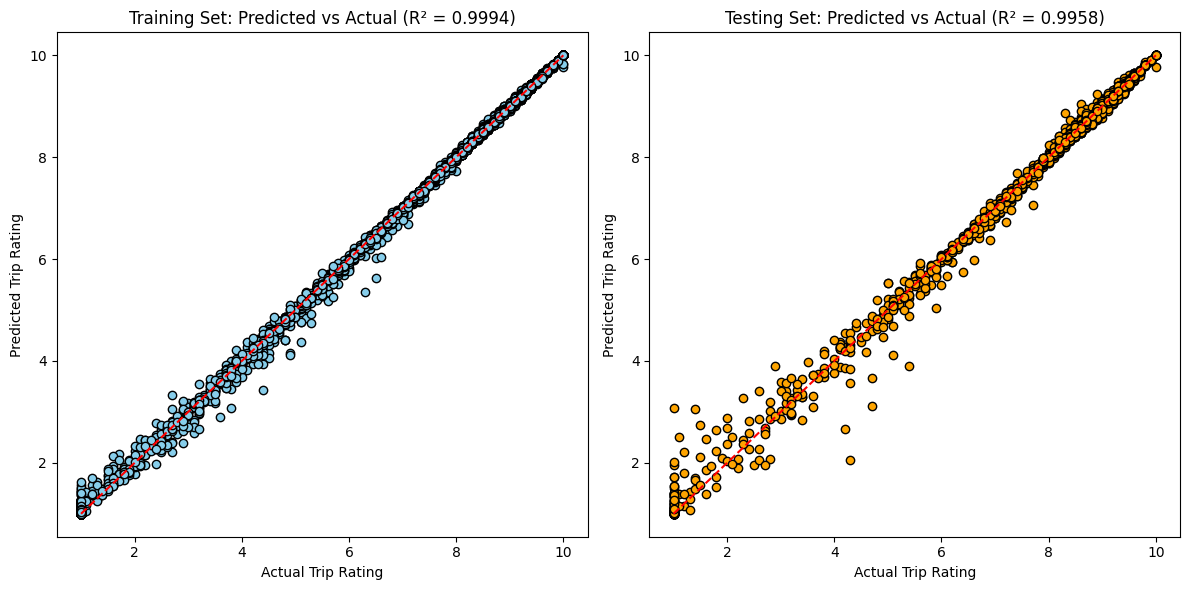

In [57]:
import matplotlib.pyplot as plt

# Training Set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='skyblue', edgecolors='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--') 
plt.xlabel("Actual Trip Rating")
plt.ylabel("Predicted Trip Rating")
plt.title(f"Training Set: Predicted vs Actual (R² = {train_r2:.4f})")

#Testing Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='orange', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.xlabel("Actual Trip Rating")
plt.ylabel("Predicted Trip Rating")
plt.title(f"Testing Set: Predicted vs Actual (R² = {test_r2:.4f})")

plt.tight_layout()
plt.show()


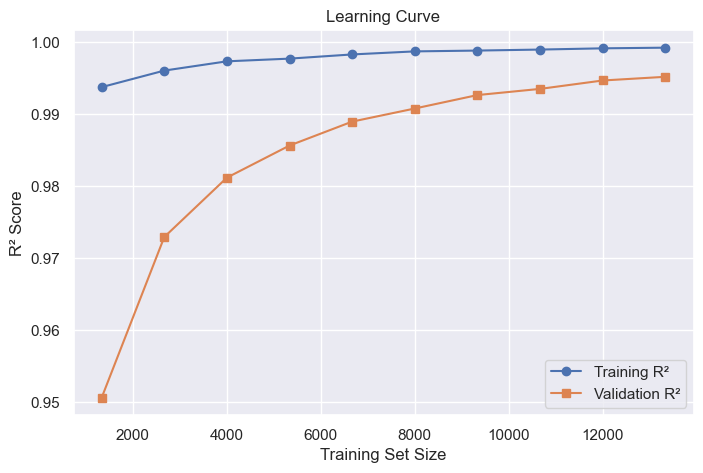

In [107]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=3, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training R²", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation R²", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [112]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


preprocessor = ColumnTransformer([
    ("scale_trip_length", StandardScaler(), ["trip_length"])
], remainder="passthrough")

# Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression(fit_intercept=False))
])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
r2train=r2_score(y_train, pipeline.predict(X_train))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
print(f"R2 Train Score: {r2train}")
print(f"R² Test Score: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R2 Train Score: 0.8209860683840855
R² Test Score: 0.8273937620014298
MAE: 0.5532741261207673
MSE: 0.6290781032190466
RMSE: 0.7931444403253713


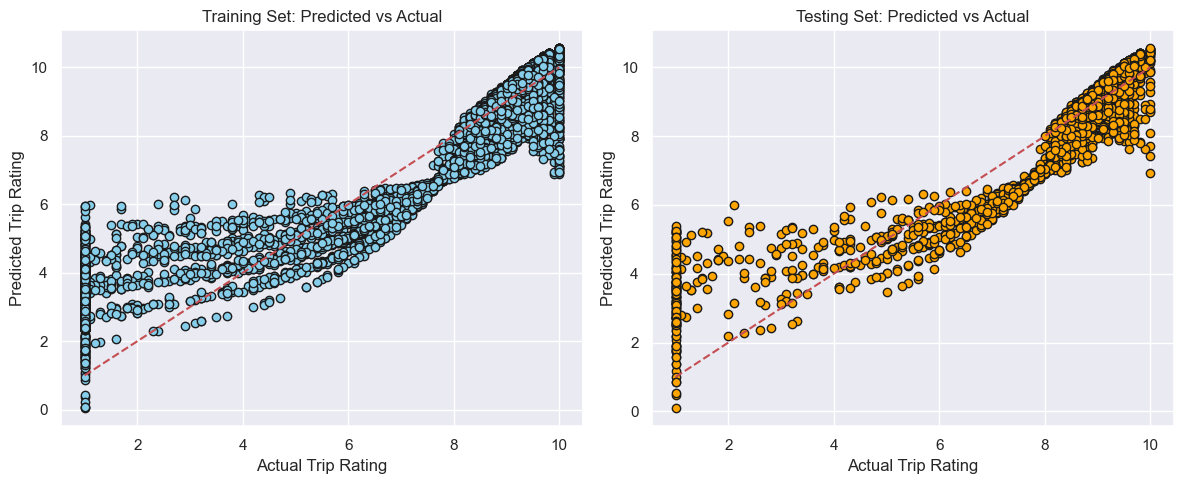

In [60]:
import matplotlib.pyplot as plt

y_train_pred = pipeline.predict(X_train)


# 1. Predicted vs Actual

plt.figure(figsize=(12, 5))

# Training Set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='skyblue', edgecolors='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Trip Rating")
plt.ylabel("Predicted Trip Rating")
plt.title("Training Set: Predicted vs Actual")

# Testing Set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='orange', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Trip Rating")
plt.ylabel("Predicted Trip Rating")
plt.title("Testing Set: Predicted vs Actual")

plt.tight_layout()
plt.show()



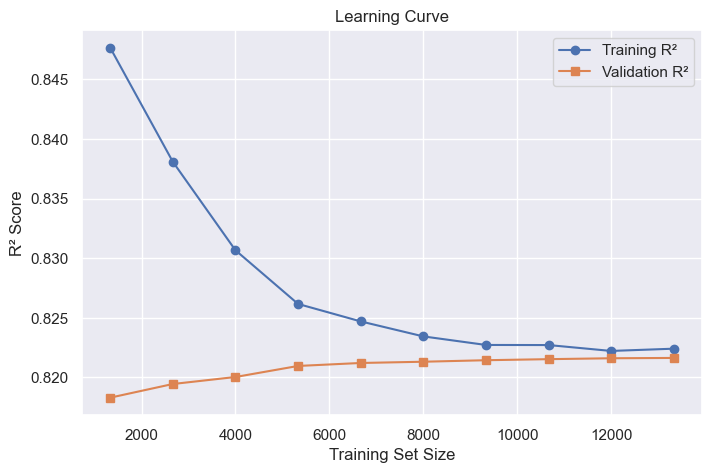

In [61]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=3, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training R²", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation R²", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
